In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import json

pd.set_option('display.max_columns', None)

import numpy as np

from votekit.ballot import Ballot
from votekit.pref_profile import PreferenceProfile
from votekit.elections import STV, Limited, Cumulative, BlocPlurality
from fractions import Fraction
import votekit.ballot_generator as bg
from votekit import PreferenceInterval

from tqdm import tqdm

### Jefferson County data:

In [2]:
precincts_df = gpd.read_parquet('./Training_Materials-main/place_specific_data/Jefferson_County-CO/Jefferson_precincts.parquet')
elections_df = pd.read_parquet('./Training_Materials-main/place_specific_data/Jefferson_County-CO/Jefferson_elections.parquet')
pop_df = pd.read_parquet('./Training_Materials-main/place_specific_data/Jefferson_County-CO/Jefferson_pop.parquet')
vap_df = pd.read_parquet('./Training_Materials-main/place_specific_data/Jefferson_County-CO/Jefferson_vap.parquet')


In [3]:
precincts_df 

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
2394,08,059,059040,08059059040,A,Jefferson 040,Jefferson 040,00,G5240,N,4601450,32622,+39.6727134,-105.3508621,"POLYGON ((-105.36518 39.67915, -105.36515 39.6..."
2395,08,059,059046,08059059046,A,Jefferson 046,Jefferson 046,00,G5240,N,2848177,396,+39.6581169,-105.3344284,"POLYGON ((-105.35509 39.66325, -105.35482 39.6..."
2396,08,059,059045,08059059045,A,Jefferson 045,Jefferson 045,00,G5240,N,4846568,491,+39.6496983,-105.3303095,"POLYGON ((-105.34599 39.65313, -105.34528 39.6..."
2397,08,059,059056,08059059056,A,Jefferson 056,Jefferson 056,00,G5240,N,5508834,2195,+39.6778288,-105.3328814,"POLYGON ((-105.35812 39.69231, -105.35699 39.6..."
2398,08,059,059044,08059059044,A,Jefferson 044,Jefferson 044,00,G5240,N,11379080,3705,+39.6656971,-105.3069466,"POLYGON ((-105.32240 39.66715, -105.32145 39.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2647,08,059,059203,08059059203,A,Jefferson 203,Jefferson 203,00,G5240,N,479096,0,+39.6366488,-105.1535623,"MULTIPOLYGON (((-105.14294 39.63854, -105.1420..."
2648,08,059,059246,08059059246,A,Jefferson 246,Jefferson 246,00,G5240,N,1073438,0,+39.6999941,-105.0927063,"POLYGON ((-105.10034 39.69773, -105.10032 39.6..."
2649,08,059,059017,08059059017,A,Jefferson 017,Jefferson 017,00,G5240,N,976567,0,+39.6126913,-105.1006016,"POLYGON ((-105.10995 39.61195, -105.10991 39.6..."
2650,08,059,059032,08059059032,A,Jefferson 032,Jefferson 032,00,G5240,N,617967,0,+39.5698152,-105.1055041,"POLYGON ((-105.11021 39.57023, -105.11020 39.5..."


In [4]:
elections_df

,pres_08_dem,pres_08_rep,pres_12_dem,pres_12_rep,pres_16_dem,pres_16_rep,sen_16_dem,sen_16_rep,gov_18_dem,gov_18_rep,ag_18_dem,ag_18_rep,pres_20_dem,pres_20_rep,sen_20_dem,sen_20_rep
VTD,,,,,,,,,,,,,,,,
vtd:08059059001,86,92,67,102,84,66,84,71,84,85,80,90,128,93,116,105
vtd:08059059002,435,435,400,538,441,456,422,484,455,435,417,462,618,523,569,578
vtd:08059059003,532,608,430,514,473,566,484,585,474,531,426,572,594,593,571,636
vtd:08059059004,597,672,729,934,587,715,605,712,551,670,533,685,720,796,699,824
vtd:08059059005,550,746,425,650,466,728,482,737,480,672,435,710,631,774,609,812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vtd:08059059254,682,515,703,465,747,465,754,461,843,479,770,547,994,563,974,594
vtd:08059059255,602,338,660,372,646,367,640,359,624,307,602,321,857,409,825,425
vtd:08059059256,816,632,916,625,846,656,889,635,837,561,783,628,1137,648,1110,664


In [5]:
pop_df

,tot_pop_20,bpop_20,hpop_20,asian_nhpi_pop_20,amin_pop_20,other_pop_20,white_pop_20
id,,,,,,,
vtd:08059059001,266,7,24,15,2,2,216
vtd:08059059002,1979,48,192,224,28,39,1448
vtd:08059059003,1690,16,205,62,29,27,1351
vtd:08059059004,2407,52,321,73,42,49,1870
vtd:08059059005,2104,21,216,53,33,41,1740
...,...,...,...,...,...,...,...
vtd:08059059254,2287,41,466,62,47,57,1614
vtd:08059059255,2555,102,1063,84,45,36,1225
vtd:08059059256,2932,59,682,166,66,28,1931


In [6]:
vap_df

,tot_vap_20,bvap_20,hvap_20,asian_nhpi_vap_20,amin_vap_20,other_vap_20,white_vap_20
id,,,,,,,
vtd:08059059001,194,6,15,4,2,2,165
vtd:08059059002,1497,42,141,166,17,28,1103
vtd:08059059003,1375,5,143,37,20,24,1146
vtd:08059059004,1879,36,225,55,33,39,1491
vtd:08059059005,1657,16,151,43,24,31,1392
...,...,...,...,...,...,...,...
vtd:08059059254,1830,38,298,41,34,42,1377
vtd:08059059255,1941,61,676,63,34,31,1076
vtd:08059059256,2432,38,504,128,62,24,1676


In [7]:
vap_df[list(vap_df.columns)].sum()

tot_vap_20           469066
bvap_20                8711
hvap_20               63544
asian_nhpi_vap_20     18861
amin_vap_20            8325
other_vap_20           6979
white_vap_20         362646
dtype: int64

In [8]:
pop_df[list(pop_df.columns)].sum()

tot_pop_20           582910
bpop_20               13031
hpop_20               89296
asian_nhpi_pop_20     25259
amin_pop_20           10724
other_pop_20           9355
white_pop_20         435245
dtype: int64

In [9]:
pop_df['hpop_20'].sum()/pop_df['tot_pop_20'].sum()

np.float64(0.15319002933557496)

In [10]:
vap_df['hvap_20'].sum()/vap_df['tot_vap_20'].sum()

np.float64(0.13546920902389004)

In [11]:
pop_df['white_pop_20'].sum()/pop_df['tot_pop_20'].sum()

np.float64(0.7466761592698702)

In [12]:
vap_df['white_vap_20'].sum()/vap_df['tot_vap_20'].sum()

np.float64(0.7731236116026317)

<Axes: >

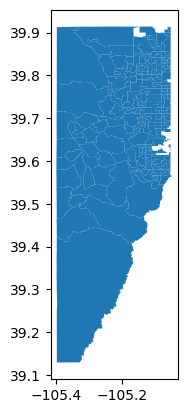

In [13]:
precincts_df.plot()

### Put all these on a single geodataframe:

In [14]:
elections_df = elections_df.reset_index()
pop_df = pop_df.reset_index()
vap_df = vap_df.reset_index()


In [15]:
elections_df

,VTD,pres_08_dem,pres_08_rep,pres_12_dem,pres_12_rep,pres_16_dem,pres_16_rep,sen_16_dem,sen_16_rep,gov_18_dem,gov_18_rep,ag_18_dem,ag_18_rep,pres_20_dem,pres_20_rep,sen_20_dem,sen_20_rep
0,vtd:08059059001,86,92,67,102,84,66,84,71,84,85,80,90,128,93,116,105
1,vtd:08059059002,435,435,400,538,441,456,422,484,455,435,417,462,618,523,569,578
2,vtd:08059059003,532,608,430,514,473,566,484,585,474,531,426,572,594,593,571,636
3,vtd:08059059004,597,672,729,934,587,715,605,712,551,670,533,685,720,796,699,824
4,vtd:08059059005,550,746,425,650,466,728,482,737,480,672,435,710,631,774,609,812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,vtd:08059059254,682,515,703,465,747,465,754,461,843,479,770,547,994,563,974,594
254,vtd:08059059255,602,338,660,372,646,367,640,359,624,307,602,321,857,409,825,425
255,vtd:08059059256,816,632,916,625,846,656,889,635,837,561,783,628,1137,648,1110,664
256,vtd:08059059257,606,641,652,710,652,726,695,708,712,651,662,691,936,735,889,809


In [16]:
pop_df

,id,tot_pop_20,bpop_20,hpop_20,asian_nhpi_pop_20,amin_pop_20,other_pop_20,white_pop_20
0,vtd:08059059001,266,7,24,15,2,2,216
1,vtd:08059059002,1979,48,192,224,28,39,1448
2,vtd:08059059003,1690,16,205,62,29,27,1351
3,vtd:08059059004,2407,52,321,73,42,49,1870
4,vtd:08059059005,2104,21,216,53,33,41,1740
...,...,...,...,...,...,...,...,...
253,vtd:08059059254,2287,41,466,62,47,57,1614
254,vtd:08059059255,2555,102,1063,84,45,36,1225
255,vtd:08059059256,2932,59,682,166,66,28,1931
256,vtd:08059059257,2575,46,293,234,31,48,1923


In [17]:
vap_df

,id,tot_vap_20,bvap_20,hvap_20,asian_nhpi_vap_20,amin_vap_20,other_vap_20,white_vap_20
0,vtd:08059059001,194,6,15,4,2,2,165
1,vtd:08059059002,1497,42,141,166,17,28,1103
2,vtd:08059059003,1375,5,143,37,20,24,1146
3,vtd:08059059004,1879,36,225,55,33,39,1491
4,vtd:08059059005,1657,16,151,43,24,31,1392
...,...,...,...,...,...,...,...,...
253,vtd:08059059254,1830,38,298,41,34,42,1377
254,vtd:08059059255,1941,61,676,63,34,31,1076
255,vtd:08059059256,2432,38,504,128,62,24,1676
256,vtd:08059059257,2190,39,225,176,26,35,1689


In [18]:
for i in elections_df.index:
    elections_df.loc[i, 'VTD'] = elections_df.loc[i, 'VTD'][4:]

for i in pop_df.index:
    pop_df.loc[i, 'id'] = pop_df.loc[i, 'id'][4:]

for i in vap_df.index:
    vap_df.loc[i, 'id'] = vap_df.loc[i, 'id'][4:]


In [19]:
precincts_df['GEOID20']

2394    08059059040
2395    08059059046
2396    08059059045
2397    08059059056
2398    08059059044
           ...     
2647    08059059203
2648    08059059246
2649    08059059017
2650    08059059032
2651    08059059186
Name: GEOID20, Length: 258, dtype: object

In [20]:
elections_df['VTD'] 

0      08059059001
1      08059059002
2      08059059003
3      08059059004
4      08059059005
          ...     
253    08059059254
254    08059059255
255    08059059256
256    08059059257
257    08059059258
Name: VTD, Length: 258, dtype: object

### Give these ID columns intelligent names!

In [21]:
elections_df = elections_df.rename(columns = {'VTD': 'GEOID20'})
pop_df = pop_df.rename(columns = {'id': 'GEOID20'})
vap_df = vap_df.rename(columns = {'id': 'GEOID20'})


In [22]:
precincts_df = precincts_df.merge(pop_df, on = 'GEOID20')
precincts_df = precincts_df.merge(vap_df, on = 'GEOID20')
precincts_df = precincts_df.merge(elections_df, on = 'GEOID20')


In [23]:
precincts_df

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,tot_pop_20,bpop_20,hpop_20,asian_nhpi_pop_20,amin_pop_20,other_pop_20,white_pop_20,tot_vap_20,bvap_20,hvap_20,asian_nhpi_vap_20,amin_vap_20,other_vap_20,white_vap_20,pres_08_dem,pres_08_rep,pres_12_dem,pres_12_rep,pres_16_dem,pres_16_rep,sen_16_dem,sen_16_rep,gov_18_dem,gov_18_rep,ag_18_dem,ag_18_rep,pres_20_dem,pres_20_rep,sen_20_dem,sen_20_rep
0,08,059,059040,08059059040,A,Jefferson 040,Jefferson 040,00,G5240,N,4601450,32622,+39.6727134,-105.3508621,"POLYGON ((-105.36518 39.67915, -105.36515 39.6...",2129,9,48,42,25,19,1986,1580,3,30,25,11,16,1495,592,808,510,933,678,698,665,753,687,722,644,746,902,669,819,793
1,08,059,059046,08059059046,A,Jefferson 046,Jefferson 046,00,G5240,N,2848177,396,+39.6581169,-105.3344284,"POLYGON ((-105.35509 39.66325, -105.35482 39.6...",1588,18,95,31,35,35,1374,1252,10,69,23,31,23,1096,525,361,509,408,514,354,507,343,554,321,528,337,689,346,666,374
2,08,059,059045,08059059045,A,Jefferson 045,Jefferson 045,00,G5240,N,4846568,491,+39.6496983,-105.3303095,"POLYGON ((-105.34599 39.65313, -105.34528 39.6...",1425,6,77,31,29,26,1256,1102,4,42,14,14,22,1006,558,383,523,411,549,350,546,375,550,352,521,364,715,375,697,410
3,08,059,059056,08059059056,A,Jefferson 056,Jefferson 056,00,G5240,N,5508834,2195,+39.6778288,-105.3328814,"POLYGON ((-105.35812 39.69231, -105.35699 39.6...",1393,12,70,23,3,30,1255,1027,8,40,13,2,25,939,427,473,387,516,446,417,431,462,418,423,392,435,573,427,521,493
4,08,059,059044,08059059044,A,Jefferson 044,Jefferson 044,00,G5240,N,11379080,3705,+39.6656971,-105.3069466,"POLYGON ((-105.32240 39.66715, -105.32145 39.6...",1458,19,73,29,27,30,1280,1136,13,41,16,23,17,1026,480,317,484,350,448,336,460,350,495,319,478,339,623,384,603,406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,08,059,059203,08059059203,A,Jefferson 203,Jefferson 203,00,G5240,N,479096,0,+39.6366488,-105.1535623,"MULTIPOLYGON (((-105.14294 39.63854, -105.1420...",786,21,100,25,13,15,612,585,11,50,21,12,11,480,212,172,300,281,192,162,206,162,187,122,180,136,277,207,269,222
254,08,059,059246,08059059246,A,Jefferson 246,Jefferson 246,00,G5240,N,1073438,0,+39.6999941,-105.0927063,"POLYGON ((-105.10034 39.69773, -105.10032 39.6...",1431,31,267,53,9,26,1045,1150,22,193,37,7,19,872,425,361,441,382,424,382,453,372,443,322,436,337,567,388,557,402
255,08,059,059017,08059059017,A,Jefferson 017,Jefferson 017,00,G5240,N,976567,0,+39.6126913,-105.1006016,"POLYGON ((-105.10995 39.61195, -105.10991 39.6...",1492,12,211,130,23,8,1108,1161,5,140,97,17,6,896,366,419,352,500,401,426,405,450,397,395,346,428,521,412,477,452
256,08,059,059032,08059059032,A,Jefferson 032,Jefferson 032,00,G5240,N,617967,0,+39.5698152,-105.1055041,"POLYGON ((-105.11021 39.57023, -105.11020 39.5...",2009,55,255,67,38,42,1552,1631,37,180,58,23,39,1294,575,435,564,532,547,488,563,484,564,366,525,388,699,540,676,551


### Use an intelligent CRS:

In [24]:
precincts_df = precincts_df.to_crs(precincts_df.estimate_utm_crs())

In [25]:
from gerrychain import Graph

In [26]:
precincts_graph = Graph.from_geodataframe(precincts_df)

/opt/miniconda3/envs/gerry2024/lib/python3.12/site-packages/gerrychain/graph/graph.py:406: UserWarning: Found islands (degree-0 nodes). Indices of islands: {240}
  warnings.warn(


In [27]:
precincts_df.loc[[240]]

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,tot_pop_20,bpop_20,hpop_20,asian_nhpi_pop_20,amin_pop_20,other_pop_20,white_pop_20,tot_vap_20,bvap_20,hvap_20,asian_nhpi_vap_20,amin_vap_20,other_vap_20,white_vap_20,pres_08_dem,pres_08_rep,pres_12_dem,pres_12_rep,pres_16_dem,pres_16_rep,sen_16_dem,sen_16_rep,gov_18_dem,gov_18_rep,ag_18_dem,ag_18_rep,pres_20_dem,pres_20_rep,sen_20_dem,sen_20_rep
240,08,059,059001,08059059001,A,Jefferson 001,Jefferson 001,00,G5240,N,472167,0,+39.6337780,-105.0558156,"MULTIPOLYGON (((495210.242 4386062.590, 495210...",266,7,24,15,2,2,216,194,6,15,4,2,2,165,86,92,67,102,84,66,84,71,84,85,80,90,128,93,116,105


In [28]:
precincts_df.to_file('./Jefferson_County_precincts.shp')

/var/folders/3v/np_dynzj0m3c6s8ws_rhvwnw0000gn/T/ipykernel_11512/3324950333.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  precincts_df.to_file('./Jefferson_County_precincts.shp')


### UGH - QGIS says the island is precinct 001, and we should add an edge between 001 and 002.

In [30]:
precincts_df[precincts_df['NAME20'].isin(['Jefferson 001', 'Jefferson 002'])]

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,tot_pop_20,bpop_20,hpop_20,asian_nhpi_pop_20,amin_pop_20,other_pop_20,white_pop_20,tot_vap_20,bvap_20,hvap_20,asian_nhpi_vap_20,amin_vap_20,other_vap_20,white_vap_20,pres_08_dem,pres_08_rep,pres_12_dem,pres_12_rep,pres_16_dem,pres_16_rep,sen_16_dem,sen_16_rep,gov_18_dem,gov_18_rep,ag_18_dem,ag_18_rep,pres_20_dem,pres_20_rep,sen_20_dem,sen_20_rep
130,08,059,059002,08059059002,A,Jefferson 002,Jefferson 002,00,G5240,N,1793976,125402,+39.6125927,-105.0747569,"POLYGON ((492154.556 4384680.802, 492154.322 4...",1979,48,192,224,28,39,1448,1497,42,141,166,17,28,1103,435,435,400,538,441,456,422,484,455,435,417,462,618,523,569,578
240,08,059,059001,08059059001,A,Jefferson 001,Jefferson 001,00,G5240,N,472167,0,+39.6337780,-105.0558156,"MULTIPOLYGON (((495210.242 4386062.590, 495210...",266,7,24,15,2,2,216,194,6,15,4,2,2,165,86,92,67,102,84,66,84,71,84,85,80,90,128,93,116,105


In [31]:
precincts_graph.nodes[130]

{'boundary_node': True,
 'boundary_perim': 5238.43425157365,
 'area': 1917841.9087733557,
 'STATEFP20': '08',
 'COUNTYFP20': '059',
 'VTDST20': '059002',
 'GEOID20': '08059059002',
 'VTDI20': 'A',
 'NAME20': 'Jefferson 002',
 'NAMELSAD20': 'Jefferson 002',
 'LSAD20': '00',
 'MTFCC20': 'G5240',
 'FUNCSTAT20': 'N',
 'ALAND20': 1793976,
 'AWATER20': 125402,
 'INTPTLAT20': '+39.6125927',
 'INTPTLON20': '-105.0747569',
 'geometry': <POLYGON ((492154.556 4384680.802, 492154.322 4384957.261, 492175.609 438495...>,
 'tot_pop_20': 1979,
 'bpop_20': 48,
 'hpop_20': 192,
 'asian_nhpi_pop_20': 224,
 'amin_pop_20': 28,
 'other_pop_20': 39,
 'white_pop_20': 1448,
 'tot_vap_20': 1497,
 'bvap_20': 42,
 'hvap_20': 141,
 'asian_nhpi_vap_20': 166,
 'amin_vap_20': 17,
 'other_vap_20': 28,
 'white_vap_20': 1103,
 'pres_08_dem': 435,
 'pres_08_rep': 435,
 'pres_12_dem': 400,
 'pres_12_rep': 538,
 'pres_16_dem': 441,
 'pres_16_rep': 456,
 'sen_16_dem': 422,
 'sen_16_rep': 484,
 'gov_18_dem': 455,
 'gov_18_re

In [32]:
precincts_graph.nodes[240]

{'boundary_node': True,
 'boundary_perim': 3885.952361492613,
 'area': 471790.4232173212,
 'STATEFP20': '08',
 'COUNTYFP20': '059',
 'VTDST20': '059001',
 'GEOID20': '08059059001',
 'VTDI20': 'A',
 'NAME20': 'Jefferson 001',
 'NAMELSAD20': 'Jefferson 001',
 'LSAD20': '00',
 'MTFCC20': 'G5240',
 'FUNCSTAT20': 'N',
 'ALAND20': 472167,
 'AWATER20': 0,
 'INTPTLAT20': '+39.6337780',
 'INTPTLON20': '-105.0558156',
 'geometry': <MULTIPOLYGON (((495210.242 4386062.59, 495210.423 4386077.794, 495212.043 4...>,
 'tot_pop_20': 266,
 'bpop_20': 7,
 'hpop_20': 24,
 'asian_nhpi_pop_20': 15,
 'amin_pop_20': 2,
 'other_pop_20': 2,
 'white_pop_20': 216,
 'tot_vap_20': 194,
 'bvap_20': 6,
 'hvap_20': 15,
 'asian_nhpi_vap_20': 4,
 'amin_vap_20': 2,
 'other_vap_20': 2,
 'white_vap_20': 165,
 'pres_08_dem': 86,
 'pres_08_rep': 92,
 'pres_12_dem': 67,
 'pres_12_rep': 102,
 'pres_16_dem': 84,
 'pres_16_rep': 66,
 'sen_16_dem': 84,
 'sen_16_rep': 71,
 'gov_18_dem': 84,
 'gov_18_rep': 85,
 'ag_18_dem': 80,
 'a

In [33]:
precincts_graph.add_edge(130, 240)

In [34]:
from networkx import is_connected

In [35]:
is_connected(precincts_graph)

True

In [36]:
precincts_graph.to_json('./Jefferson_County_precincts.json')